In [1]:
# Most recently tested against PySAM 3.0.1

import pandas as pd
import json
import numpy as np
import PySAM.Pvwattsv7 as pvwatts
import matplotlib.pyplot as plt

### Read sample data

In [2]:
data = pd.read_csv("NonAnnualSimulation-sample_data.csv")
data["Timestamp"] = pd.DatetimeIndex(pd.to_datetime(data["Timestamp"], utc=True))
data = data.set_index("Timestamp")

In [3]:
data.head()

,SRRL BMS Wind Speed at 19' (m/s),SRRL BMS Direct Normal Irradiance (W/m²_irr),SRRL BMS Wind Speed at 6' (m/s),SRRL BMS Global Horizontal Irradiance (W/m²_irr),SRRL BMS Peak Wind Speed at 6' (m/s),SRRL BMS Peak Wind Speed at 19' (m/s),SRRL BMS Dry Bulb Temperature (°C),SRRL BMS Opaque Cloud Cover (%),SRRL BMS Diffuse Horizontal Irradiance (W/m²_irr),SRRL BMS Total Cloud Cover (%),Energy (kW),SRRL BMS Snow Depth (in)
Timestamp,,,,,,,,,,,,
2018-05-10 00:00:00+00:00,1.100001,7.133315,0.517000,170.042892,0.950001,1.450001,21.250000,86.0,169.190201,99.0,102.915649,0.0
2018-05-10 00:01:00+00:00,1.438001,6.578963,0.133000,165.777206,1.450001,2.200001,21.240001,85.0,165.126404,99.0,100.472260,0.0
2018-05-10 00:02:00+00:00,1.675001,8.639463,0.895001,162.191299,1.450001,2.200001,21.280000,84.0,160.799606,98.0,98.063423,0.0
2018-05-10 00:03:00+00:00,1.513001,10.877770,1.338001,157.971497,1.950001,2.200001,21.320000,82.0,155.850006,98.0,94.587265,0.0
2018-05-10 00:04:00+00:00,1.750001,11.107880,1.325001,153.181595,1.700001,2.450001,21.340001,79.0,151.059006,97.0,90.573120,0.0


In [4]:
weather_data = np.array([
    data.index.year,
    data.index.month,
    data.index.day,
    data.index.hour,
    data.index.minute,
    data['SRRL BMS Direct Normal Irradiance (W/m²_irr)'],
    data['SRRL BMS Diffuse Horizontal Irradiance (W/m²_irr)'],
    data['SRRL BMS Global Horizontal Irradiance (W/m²_irr)'],
    data["SRRL BMS Wind Speed at 19' (m/s)"],
    data['SRRL BMS Dry Bulb Temperature (°C)']
])

### Set model parameters

In [5]:
sys_design = {
    "ModelParams": {
        "SystemDesign": {
            "array_type": 2.0,
            "azimuth": 180.0,
            "dc_ac_ratio": 1.08,
            "gcr": 0.592,
            "inv_eff": 97.5,
            "losses": 15.53,
            "module_type": 2.0,
            "system_capacity": 720,
            "tilt": 0.0
        },
        "SolarResource": {
        }
    },
    "Other": {
        "lat": 39.7442,
        "lon": -105.1778,
        "elev": 1829
    }
}
    
model_params = sys_design['ModelParams']
elev = sys_design['Other']['elev']
lat = sys_design['Other']['lat']
lon = sys_design['Other']['lon']
tz = data.index[0].utcoffset().total_seconds()/60/60

### Make predictions

In [6]:
system_model = pvwatts.new()
system_model.assign(model_params)

solar_resource_data = {
        'tz': tz, # timezone
        'elev': elev, # elevation
        'lat': lat, # latitude
        'lon': lon, # longitude
        'year': tuple(weather_data[0]), # year
        'month': tuple(weather_data[1]), # month
        'day': tuple(weather_data[2]), # day
        'hour': tuple(weather_data[3]), # hour
        'minute': tuple(weather_data[4]), # minute
        'dn': tuple(weather_data[5]), # direct normal irradiance
        'df': tuple(weather_data[6]), # diffuse irradiance
        'gh': tuple(weather_data[7]), # global horizontal irradiance
        'wspd': tuple(weather_data[8]), # windspeed
        'tdry': tuple(weather_data[9]) # dry bulb temperature
        }

system_model.SolarResource.assign({'solar_resource_data': solar_resource_data})
system_model.AdjustmentFactors.assign({'constant': 0})

system_model.execute()
out = system_model.Outputs.export()

ac = np.array(out['ac']) / 1000
dc = np.array(out['dc']) / 1000

predictions = pd.DataFrame({"ac": ac, "dc": dc}, columns = ['ac','dc'])
predictions = predictions.set_index(data.index.copy())        

Text(0, 0.5, 'Energy (kW)')

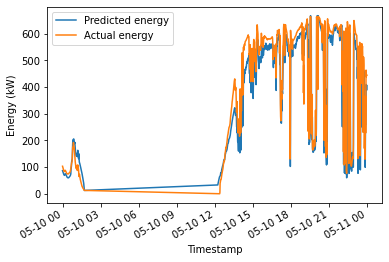

In [7]:
predictions['ac'].plot()
data['Energy (kW)'].plot()
plt.legend(["Predicted energy", "Actual energy"])
plt.ylabel("Energy (kW)")